In [1]:
from absl import logging
import numpy as np
import tensorflow.compat.v1 as tf

from open_spiel.python import rl_environment
from open_spiel.python.algorithms import dqn
from open_spiel.python.algorithms import random_agent
from open_spiel.python.algorithms import minimax
from open_spiel.python.algorithms import minimax_agent

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-12-03 17:35:34.517127: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Training parameters
#Directory to save/load the agent models.
checkpoint_dir = "/Users/titus/Desktop/MLAgents/Checkers2"
#checkpoint_dir = 
#Episode frequency at which the DQN agent models are saved
save_every = int(1e4)

#Number of training episodes.
num_train_episodes = int(1e6)

#Episode frequency at which the DQN agents are evaluated.
eval_every = 100


# DQN model hyper-parameters

#Number of hidden units in the Q-Network MLP
hidden_layers_sizes = [64, 64]

#Size of the replay buffer
replay_buffer_capacity = int(1e5)

#Number of transitions to sample at each learning step.                     
batch_size = 32

In [3]:
def evaluate(state):
  kWhite = state.observation_string().count('o')
  kWhiteKing = state.observation_string().count('8') - 1 #one row is also labeld 8
  kBlack = state.observation_string().count('+') 
  kBlackKing = state.observation_string().count('*')
  return -1 * state.current_player() * (kWhite + 2*kWhiteKing - kBlack - 2*kBlackKing) #player 0 moves white pieces

In [4]:
game = "checkers"
num_players = 2
env = rl_environment.Environment(game)
info_state_size = env.observation_spec()["info_state"][0]
num_actions = env.action_spec()["num_actions"]

#minimax agents for evaluation
minimax_agents = [
    minimax_agent.MiniMaxAgent(env.game, env.get_state, player_id=idx, num_actions=num_actions, maximum_depth=8, value_function=evaluate)
    for idx in range(num_players)
]
sess = tf.Session()

with sess.as_default():
    agents = [
          dqn.DQN(
              session=sess,
              player_id=idx,
              state_representation_size=info_state_size,
              num_actions=num_actions,
              hidden_layers_sizes=hidden_layers_sizes,
              replay_buffer_capacity=replay_buffer_capacity,
              batch_size=batch_size) for idx in range(num_players)
      ]
    for agent in agents:
        agent.restore(checkpoint_dir)

INFO:tensorflow:Restoring parameters from /Users/titus/Desktop/MLAgents/Checkers2/q_network_pid0


2023-12-03 17:35:43.155353: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
INFO:tensorflow:Restoring parameters from /Users/titus/Desktop/MLAgents/Checkers2/q_network_pid0


INFO:tensorflow:Restoring parameters from /Users/titus/Desktop/MLAgents/Checkers2/target_q_network_pid0


INFO:tensorflow:Restoring parameters from /Users/titus/Desktop/MLAgents/Checkers2/target_q_network_pid0


INFO:tensorflow:Restoring parameters from /Users/titus/Desktop/MLAgents/Checkers2/q_network_pid1


INFO:tensorflow:Restoring parameters from /Users/titus/Desktop/MLAgents/Checkers2/q_network_pid1


INFO:tensorflow:Restoring parameters from /Users/titus/Desktop/MLAgents/Checkers2/target_q_network_pid1


INFO:tensorflow:Restoring parameters from /Users/titus/Desktop/MLAgents/Checkers2/target_q_network_pid1


In [6]:
def eval_against_minimax(env, trained_agents, minimax_agents, num_episodes):
  """Evaluates `trained_agents` against `minimax` for `num_episodes`."""
  num_players = len(trained_agents)
  sum_episode_rewards = np.zeros(num_players)
  for player_pos in range(num_players):
    cur_agents = minimax_agents[:]
    cur_agents[player_pos] = trained_agents[player_pos]
    print(cur_agents)
    for _ in range(num_episodes):
      time_step = env.reset()
      episode_rewards = 0
      while not time_step.last():
        player_id = time_step.observations["current_player"]
        if player_id == player_pos:
          agent_output = cur_agents[player_id].step(
              time_step, is_evaluation=True)
          action_list = [agent_output.action]
        else:
          agent_output = cur_agents[player_id].step(time_step, is_evaluation=True, state=env.get_state)
          action_list = [agent_output.action]
        time_step = env.step(action_list)
        episode_rewards += time_step.rewards[player_pos]
      sum_episode_rewards[player_pos] += episode_rewards
  return sum_episode_rewards / num_episodes

In [7]:
def eval_against_minimax2(env, trained_agents, minimax_agents, num_episodes, value_function):
  """Evaluates `trained_agents` against `minimax` for `num_episodes`."""
  num_players = len(trained_agents)
  sum_episode_rewards = np.zeros((2,2))
  for player_pos in range(num_players):
    cur_agents = minimax_agents[:]
    cur_agents[player_pos] = trained_agents[player_pos]
    print("DQN Agent Player ID ", player_pos)
    for _ in range(num_episodes):
      time_step = env.reset()
      episode_rewards = [0,0]
      while not time_step.last():
        player_id = time_step.observations["current_player"]
        if player_id == player_pos:
          agent_output = cur_agents[player_id].step(
              time_step, is_evaluation=True)
          action_list = [agent_output.action]
        else:
          _ , action = minimax.alpha_beta_search(env.game, 
                                           env.get_state, 
                                           value_function=evaluate, 
                                           maximum_depth = 2,
                                           maximizing_player_id=player_id)
          action_list = [action]
        time_step = env.step(action_list)
        
        for player_id in range(2):
          episode_rewards[player_id] += time_step.rewards[player_id] 
      print(episode_rewards)
      for player_id in range(2):
        sum_episode_rewards[player_pos, player_id] += episode_rewards[player_id]
  return sum_episode_rewards

In [8]:
def eval_against_minimax3(env, trained_agents, minimax_agents, value_function, maximum_depth):
  """Evaluates `trained_agents` against `minimax` for."""
  num_players = len(trained_agents)
  sum_episode_rewards = np.zeros(num_players)
  for player_pos in range(num_players):
    cur_agents = minimax_agents[:]
    cur_agents[player_pos] = trained_agents[player_pos]
    time_step = env.reset()
    episode_rewards = 0
    while not time_step.last():
      player_id = time_step.observations["current_player"]
      if player_id == player_pos:
        agent_output = cur_agents[player_id].step(time_step, is_evaluation=True)
        action_list = [agent_output.action]
      else:
        _ , action = minimax.alpha_beta_search(env.game, env.get_state, value_function=value_function, maximum_depth = maximum_depth, maximizing_player_id=player_id)
        action_list = [action]
      time_step = env.step(action_list)
    sum_episode_rewards[player_pos] = time_step.rewards[player_pos]    
  return sum_episode_rewards

In [9]:
import pyspiel 

game = pyspiel.load_game("checkers")
state = game.new_initial_state()

state.apply_action(322)
print(state)
print(state.current_player())

8.+.+.+.+
7+.+.+.+.
6.+.+.+.+
5........
4.o......
3..o.o.o.
2.o.o.o.o
1o.o.o.o.
 abcdefgh

1


In [12]:
with sess.as_default():
    agents2 = [agents[1], agents[0]]
    #print(eval_against_minimax2(env, agents2, minimax_agents, 3, value_function=evaluate))
    #print(eval_against_minimax2(env, agents, minimax_agents, 1, value_function=evaluate))
    #print(eval_against_minimax3(env, agents, minimax_agents, evaluate, 7))

DQN Agent Player ID  0
[0.0, 0.0]
DQN Agent Player ID  1
[-1.0, 1.0]
[[ 0.  0.]
 [-1.  1.]]


In [17]:
with tf.Session() as sess:
  hidden_layers_sizes = [int(l) for l in hidden_layers_sizes]
  # pylint: disable=g-complex-comprehension
  agents = [
      dqn.DQN(
          session=sess,
          player_id=idx,
          state_representation_size=info_state_size,
          num_actions=num_actions,
          hidden_layers_sizes=hidden_layers_sizes,
          replay_buffer_capacity=replay_buffer_capacity,
          batch_size=batch_size) for idx in range(num_players)
  ]
  sess.run(tf.global_variables_initializer())

  result = []
  print("Start Training...")
  for ep in range(num_train_episodes):
    if (ep + 1) % 100 == 0:
        print(ep+1)
    if (ep + 1) % eval_every == 0:
      r_mean = eval_against_minimax(env, agents, minimax_agents, 1)
      logging.info("[%s] Mean episode rewards %s", ep + 1, r_mean)
      print("Mean episode rewards", ep + 1, r_mean)
      result.append(r_mean)
    if (ep + 1) % save_every == 0:
      for agent in agents:
        agent.save(checkpoint_dir)

    time_step = env.reset()
    while not time_step.last():
      player_id = time_step.observations["current_player"]
      if env.is_turn_based:
        agent_output = agents[player_id].step(time_step)
        action_list = [agent_output.action]
      else:
        agents_output = [agent.step(time_step) for agent in agents]
        action_list = [agent_output.action for agent_output in agents_output]
      time_step = env.step(action_list)

    # Episode is over, step all agents with final info state.
    for agent in agents:
      agent.step(time_step)
    

2023-12-03 17:30:30.862876: W tensorflow/c/c_api.cc:300] Operation '{name:'mlp_7/bias_2/Assign' id:1229 op device:{requested: '', assigned: ''} def:{{{node mlp_7/bias_2/Assign}} = Assign[T=DT_FLOAT, _class=["loc:@mlp_7/bias_2"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](mlp_7/bias_2, mlp_7/zeros_2)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Start Training...
100
[<open_spiel.python.algorithms.dqn.DQN object at 0x13c49f5d0>, <open_spiel.python.algorithms.minimax_agent.MiniMaxAgent object at 0x13c2ff210>]
[<open_spiel.python.algorithms.minimax_agent.MiniMaxAgent object at 0x10d20d9d0>, <open_spiel.python.algorithms.dqn.DQN object at 0x13c304450>]
Mean episode rewards 100 [0. 1.]
200
[<open_spiel.python.algorithms.dqn.DQN object at 0x13c49f5d0>, <open_spiel.python.algorithms.minimax_agent.MiniMaxAgent object at 0x13c2ff210>]
[<open_spiel.python.algorithms.minimax_agent.MiniMaxAgent object at 0x10d20d9d0>, <open_spiel.python.algorithms.dqn.DQN object at 0x13c304450>]
Mean episode rewards 200 [1. 1.]
300
[<open_spiel.python.algorithms.dqn.DQN object at 0x13c49f5d0>, <open_spiel.python.algorithms.minimax_agent.MiniMaxAgent object at 0x13c2ff210>]
[<open_spiel.python.algorithms.minimax_agent.MiniMaxAgent object at 0x10d20d9d0>, <open_spiel.python.algorithms.dqn.DQN object at 0x13c304450>]
Mean episode rewards 300 [1. 1.]
400
[<o

KeyboardInterrupt: 

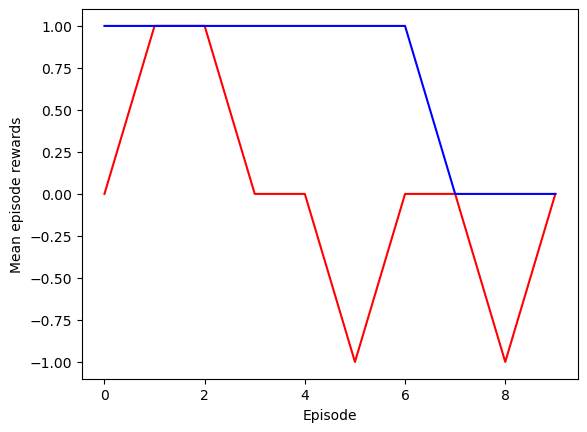

In [18]:
import matplotlib.pyplot as plt

ep = [x for x in range(len(result))]
pt_r_mean0 = [y[0] for y in result]
pt_r_mean1 = [y[1] for y in result]

plt.plot(ep,pt_r_mean0, c='red')
plt.plot(ep,pt_r_mean1, c='blue')
plt.xlabel('Episode')
plt.ylabel('Mean episode rewards')
plt.show()